In [1]:
%load_ext autoreload
%autoreload 2

import IPython.display

import collections
import imageio
import os
import sys

import numpy as np
import PIL
import torch
import torchvision
from tqdm.auto import tqdm

import matplotlib.animation as animation
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../models'))
from DCGAN.model import initialize_weights, Generator, Discriminator

# Config

In [4]:
IMAGE_SIZE = 64
BASE_FEATURES_DEPTH = 64
BATCH_SIZE = 64
LATENT_DIM = 100

BETA_1 = 0.5  # hyperparameter of Adam
LEARNING_RATE = 0.0002
D_TO_G_STEPS_RATIO = 5

device = torch.device('cuda:0')

# Data loading

# EDA

In [5]:
image_folder = torchvision.datasets.ImageFolder(
    '../data/processed/DCGAN',
    transform=torchvision.transforms.Compose(
        (
           torchvision.transforms.Resize(IMAGE_SIZE),
           torchvision.transforms.CenterCrop(IMAGE_SIZE),
           torchvision.transforms.ToTensor(),
        )
    )
)

dataloader = torch.utils.data.DataLoader(
    image_folder, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=4
)

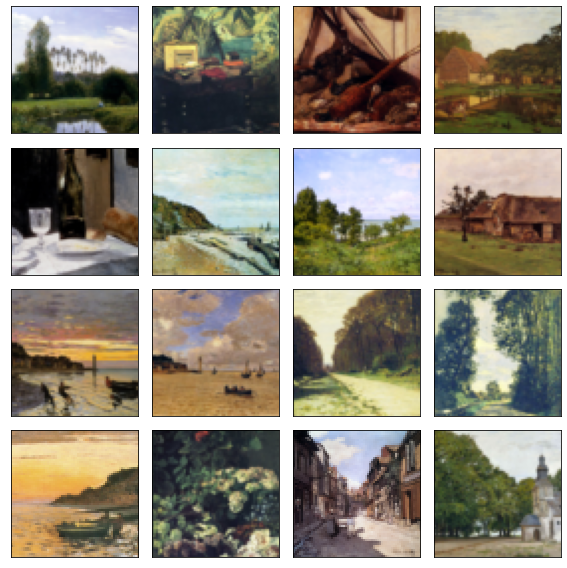

In [6]:
GRID_SIZE = 4

fig, axes = plt.subplots(
    GRID_SIZE, 
    GRID_SIZE, 
    figsize=(8, 8), 
    sharex='all', 
    sharey='all',
)

for i in range(axes.size):
    ax = axes[i // GRID_SIZE][i % GRID_SIZE]
    ax.imshow(
        (255 * image_folder[i][0].permute(1, 2, 0))
        .numpy()
        .astype(np.uint8)
    )
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

# DCGAN

## Generator

In [7]:
generator = Generator(
    latent_space_dim=LATENT_DIM, 
    base_features_depth=BASE_FEATURES_DEPTH
).to(device)
generator.apply(initialize_weights)
optimizer_generator = torch.optim.Adam(
    generator.parameters(), 
    lr=LEARNING_RATE, 
    betas=(BETA_1, 0.999)
)

## Discriminator

In [8]:
discriminator = Discriminator(
    base_features_depth=BASE_FEATURES_DEPTH
).to(device)
discriminator.apply(initialize_weights);
optimizer_discriminator = torch.optim.Adam(
    discriminator.parameters(), 
    lr=LEARNING_RATE, # needs to be increased if SpectralNorm is used
    betas=(BETA_1, 0.999)
)

## Training loop

In [9]:
num_epochs = 500
loss_fn = torch.nn.BCELoss()
fixed_noize = torch.randn(
    64, LATENT_DIM, 1, 1, 
    dtype=torch.float32, device=device
)

FAKE_LABEL = 0
REAL_LABEL = 1

img_list = []
G_losses = []
D_losses = []
iter_counter = 0

for epoch in tqdm(range(num_epochs), desc='epoch'):
    for batch_id, batch in enumerate(dataloader):
        real_paintings = batch[0].to(device) 
        batch_size = real_paintings.size(0)
        labels = torch.full(
            (batch_size, ), REAL_LABEL, 
            dtype=torch.float32, device=device
        ) 
        for _ in range(D_TO_G_STEPS_RATIO):
            # 1. Update discriminator 
            discriminator.zero_grad()
            # 1.1. Run in on real data.
            # Batch = (data, dummy label).

            predicted_proba = discriminator(real_paintings).view(-1)
            D_loss_real = loss_fn(predicted_proba, labels)
            D_loss_real.backward()
        
            # 1.2. Run it on fake data
            noise = torch.randn(
                batch_size, LATENT_DIM, 1, 1, 
                dtype=torch.float32, device=device
            )
            fake_paintings = generator(noise)
            labels.fill_(FAKE_LABEL)
            predicted_proba = discriminator(fake_paintings.detach()).view(-1)
            print(predicted_proba.size())
            D_loss_fake = loss_fn(predicted_proba, labels)
            D_loss_fake.backward()
            
            D_loss = D_loss_real + D_loss_fake
            optimizer_discriminator.step()
            D_losses.append(D_loss.detach().cpu().item())
        
        # 2. Update generator
        generator.zero_grad()
        # Generator tries to maximize the probability of misclassification
        noise = torch.randn(
            batch_size, LATENT_DIM, 1, 1, 
            dtype=torch.float32, device=device
        )
        fake_paintings = generator(noise)
        predicted_proba = discriminator(fake_paintings).view(-1)
        labels.fill_(REAL_LABEL)
        # Here the gradients of discriminator are already set to 0,
        G_loss = loss_fn(predicted_proba, labels)
        G_loss.backward()
        optimizer_generator.step()
        G_losses.append(G_loss.detach().cpu().item())
        
    if epoch % 10 != 0:
        continue 
        
    with torch.no_grad():
        fixed_fake_paintings = (
            0.5 * (generator(fixed_noize)
            .permute(0, 2, 3, 1)
            .cpu()
            .numpy() + 1)
        )
        img_list.append(fixed_fake_paintings[0])
        IPython.display.clear_output()
        print(
            f'Epoch {epoch}.\n'
            f'- D-loss: {D_losses[-1]}\n'
            f'- G-loss: {G_losses[-1]}\n'
        )
        fig, axes = plt.subplots(
            GRID_SIZE, 
            GRID_SIZE, 
            figsize=(8, 8), 
            sharex='all', 
            sharey='all',
        )

        for i in range(axes.size):
            ax = axes[i // GRID_SIZE][i % GRID_SIZE]
            ax.imshow(
                (255 * fixed_fake_paintings[i])
                .astype(np.uint8)
            )
            ax.set_xticks([])
            ax.set_yticks([])

        fig.tight_layout()
        plt.show()

epoch:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([1024])


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([1024])) is deprecated. Please ensure they have the same size.

In [ ]:
imageio.mimwrite(
    'DCGAN_64.gif',
    [
        (255 * img.clip(0, 1)).astype(np.uint8)
        for img in img_list
    ], 
    fps=1
)

In [62]:
IPython.display.Image(url='DCGAN_64.gif')